# Grid Cells

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from grid_cells import GridCells, GridCellModule
from utils import gaussian_grid, device
from tqdm import tqdm


def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

In [2]:
lin = np.linspace(-1, 1, 400)
coords = np.stack(np.meshgrid(lin, lin)).transpose(1, 2, 0)
coord = [0, 0]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.001)
place = gaussian_grid(coords, [mvn])
place /= place.max()

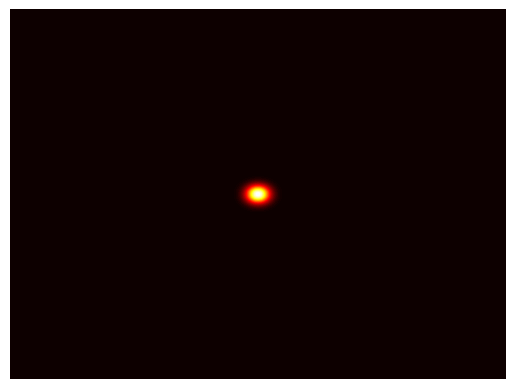

In [3]:
plt.contourf(place, levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [4]:
grid_cells = GridCells(np.linspace(100, 200, 5, dtype=int), n_per_module=25, heterogeneous=True, modular_peaks=True, individual=True)
grid_cells.reset_modules(1)
grid_cells.compile_numpy()

In [6]:
gcm = grid_cells.modules[0]

In [13]:
from skimage.draw import line_aa

In [14]:
lines = gcm.lines_at_60()
lines = [gcm.zeros_with_line(*line_aa(*l)) for l in lines]

image = np.sum(lines, axis=0) > 1
image = gcm.clean_image(image).astype(float)

In [64]:
gcs = np.tile(image, (gcm.n, 1, 1))
gcs *= np.random.uniform(0.1, 10, gcs.shape)

In [67]:
def convolve(image, kernel):
    kernel /= kernel.max()
    shape = (image.shape[0], *(np.asarray(kernel.shape[1:]) // 2 + image.shape[1:]))
    conv = np.fft.rfftn(image, shape) * np.fft.rfftn(kernel, shape)
    conv = np.fft.irfftn(conv)
    conv = np.where(np.isclose(conv, 0, atol=1e-4), 0, conv) # remove noise
    return conv[:,-image.shape[1]:, -image.shape[2]:]

In [68]:
gcs = convolve(gcs, gcm.get_gaussian_kernel().reshape(1, gcm.scale, gcm.scale))

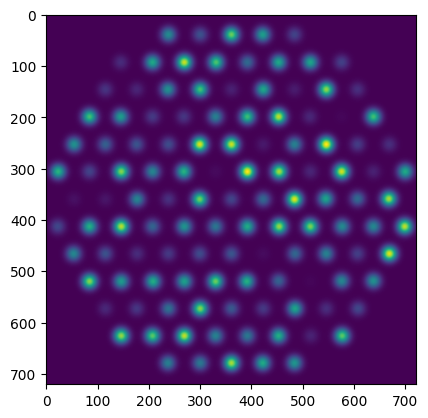

In [81]:
plt.imshow(gcs[0])

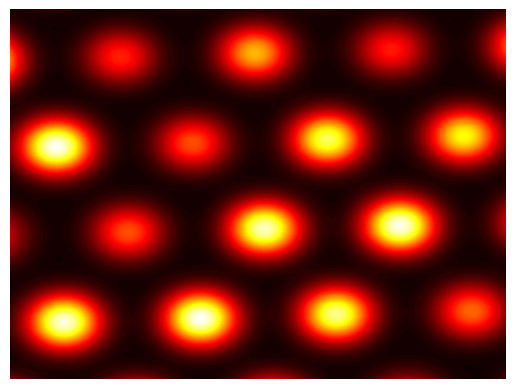

In [5]:
plt.contourf(grid_cells[12 + 25 * 4], levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [6]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
w = torch.randn(grid_cells.shape[0], requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 5e-6

for _ in tqdm(range(10000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 287.99it/s]


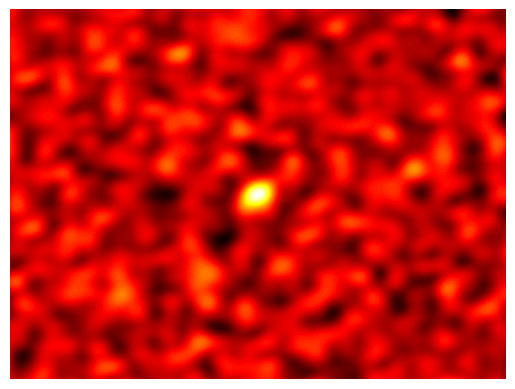

In [7]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [8]:
coord = [-.5, -.5]
mvn = multivariate_normal(mean=coord, cov=np.eye(2) * 0.01)
place = gaussian_grid(coords, [mvn])
place /= place.max()

In [9]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
w = torch.randn(grid_cells.shape[0], requires_grad=True, device=device)
pl = torch.tensor(place, dtype=torch.float32, device=device)
lr = 1e-6

for _ in tqdm(range(20000)):
    loss = torch.sum((p @ w - pl)**2 * (pl + 0.1))
    loss.backward(inputs=[w])
    w = w - lr * w.grad

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:47<00:00, 425.46it/s]


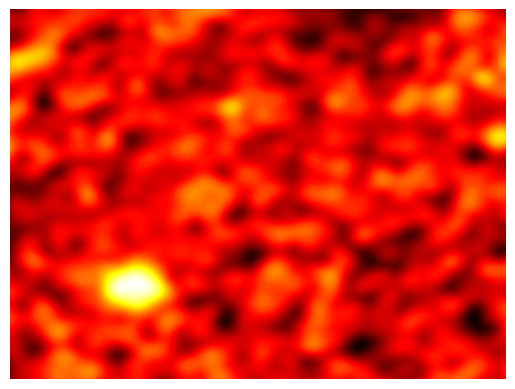

In [10]:
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()

In [13]:
grid_cells.reset_modules(3)
grid_cells.compile_numpy()

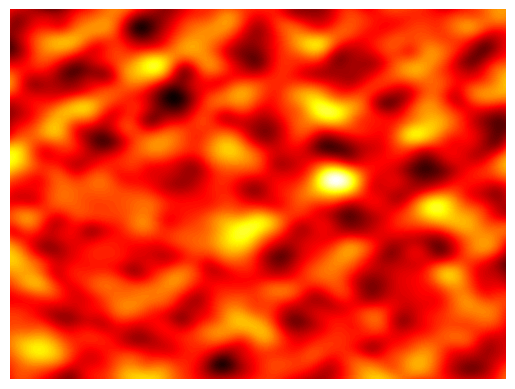

In [14]:
p = torch.tensor(grid_cells.grid_cells, dtype=torch.float32, device=device).permute(1, 2, 0)
plt.contourf((p @ w).detach().cpu(), levels=100, cmap='hot')
plt.axis('off')
plt.show()